<a href="https://colab.research.google.com/github/RefineX/Change-Detection/blob/main/AML_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Data Downloader
dataset = "LEVIRCD_Plus" #@param ["S2Looking", "LEVIRCD_Plus"]
resize = "512" #@param ["1024", "512", "256"]
crop = "256" #@param ["1024", "512", "256"]

data_link_dict = {
    'S2Looking': {
      '1024_512': "1-0_vcODMYmyYIY_uhMcs97aAk2OJVduq&confirm=t",
      '1024_256': "1-0mVd6BjKnG3LXhYkbyxdx0-dtRKY6KO&confirm=t",
      '512_512': "1-6WOmE0LTJ4Z31EphmA0L8QY5NMMllsT&confirm=t",
      '512_256': "1-7NSOmHTsDpkEtbgt_N4VSgipCo5kr3a&confirm=t",
      '256_256': "1-8x5d5DrNsgJ5eAOYyKwi91g8knGeRjQ&confirm=t",
      '1024_1024': "1GzrgMwJKguXSWSfFsBSC2qSr52fVEc7W&confirm=t"
    },
    'LEVIRCD_Plus': {
      '1024_512': "1-22GjfF8mlLFNyoJaa6_GMJRfTCoGZyc&confirm=t",
      '1024_256': "1-2r-zCCfQjLRtwwXMGPYAxEJcTS8Hp80&confirm=t",
      '512_512': "1-43scZrxe3Q_PH2EnBRuc_6l9O9WjPs2&confirm=t",
      '512_256': "1-5oC0xV36S4K5VMiQuwheWoyMt1ymYb9&confirm=t",
      '256_256': "1-69cdgqlcXunt5vrCR9jRvcMkpPNzYWr&confirm=t",
      '1024_1024': "1nyPJZGGOL7o8A0m0rGw7wyu2BFIxC4SD&confirm=t"
    }
}

import os
if os.path.exists(f'Data/{dataset}/{resize}_{crop}'):
  print('This dataset already exists.')
else:
  gdown_link = data_link_dict[dataset][f'{resize}_{crop}']
  !gdown "{gdown_link}"
  print('Unzipping...',end='')
  !unzip -q "{resize}_{crop}.zip"
  print('Done.\nDeleting zip...',end='')
  !rm "{resize}_{crop}.zip"
  print('Done.')

Downloading...
From: https://drive.google.com/uc?id=1-5oC0xV36S4K5VMiQuwheWoyMt1ymYb9&confirm=t
To: /content/512_256.zip
100% 317M/317M [00:04<00:00, 73.7MB/s]
Unzipping...Done.
Deleting zip...Done.


In [2]:
# Import libraries
import tensorflow as tf
# import os
# import time
import numpy as np
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt
# from IPython import display
import cv2
import pywt
from tensorflow.keras.models import load_model

In [3]:
# Dataset Characteristics
dataset = "LEVIRCD_Plus" #@param ["S2Looking", "LEVIRCD_Plus"]
resized_size = "512" #@param [1024, 512, 256]
crop_size = "256" #@param [1024, 512, 256]
resized_size = int(resized_size)
crop_size = int(crop_size)
if dataset == 'S2Looking':
  pre_image = 'Image1'
  post_image = 'Image2'
elif dataset == 'LEVIRCD_Plus':
  pre_image = 'A'
  post_image = 'B'
label_image = 'label'
PATH = f"/content/Data/{dataset}/{resized_size}_{crop_size}"
Path('saved/models/').mkdir(parents=True, exist_ok=True)
Path('saved/histories/').mkdir(parents=True, exist_ok=True)

In [4]:
# Metrics

def iou(y_true,y_pred):
  y_pred = tf.argmax(y_pred,-1)
  y_true = tf.argmax(y_true,-1)
  tp = tf.cast(tf.reduce_sum(y_pred*y_true,axis=[1,2]), 'float32')
  fp = tf.cast(tf.reduce_sum(y_pred*(1-y_true),axis=[1,2]), 'float32')
  fn = tf.cast(tf.reduce_sum((1-y_pred)*y_true,axis=[1,2]), 'float32')
  iou_value = (tp + 1e-14) / (tp + fp + fn + 1e-14)
  return tf.reduce_mean(iou_value)

def miou(y_true,y_pred):
  y_pred = tf.argmax(y_pred,-1)
  y_true = tf.argmax(y_true,-1)
  tp = tf.cast(tf.reduce_sum(y_pred*y_true,axis=[1,2]), 'float32')
  tn = tf.cast(tf.reduce_sum((1-y_pred)*(1-y_true),axis=[1,2]), 'float32')
  fp = tf.cast(tf.reduce_sum(y_pred*(1-y_true),axis=[1,2]), 'float32')
  fn = tf.cast(tf.reduce_sum((1-y_pred)*y_true,axis=[1,2]), 'float32')
  iou1 = (tp + 1e-14) / (tp + fp + fn + 1e-14)
  iou2 = (tn + 1e-14) / (tn + fp + fn + 1e-14)
  iou_value = (iou1 + iou2) / 2
  return tf.reduce_mean(iou_value)

# Losses

# Phase I: Initial Model Selection

In [5]:
# Downloading FC-EF, Siam-Conc, Siam-Diff
!gdown "1QwvuA0Bn0wwiJ3ZnWOYsQw7PJfLQCFWh&confirm=t"
!gdown "1KC0XJRSwj8bhnRLH2v09KyByU9RxMZf5&confirm=t"
!gdown "1K7M1zOqEH-yCBSJO2gS8EKmRyW1vu8OY&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1QwvuA0Bn0wwiJ3ZnWOYsQw7PJfLQCFWh&confirm=t
To: /content/saved_LEVIRCD_Plus_resnet18_model_ef_0.5502.zip
100% 156M/156M [00:00<00:00, 227MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KC0XJRSwj8bhnRLH2v09KyByU9RxMZf5&confirm=t
To: /content/saved_LEVIRCD_Plus_resnet18_model_siamconc_0.5361.zip
100% 174M/174M [00:02<00:00, 74.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1K7M1zOqEH-yCBSJO2gS8EKmRyW1vu8OY&confirm=t
To: /content/LEVIRCD_Plus_resnet18_model_siamdiff_0.5080.zip
100% 169M/169M [00:02<00:00, 61.7MB/s]


In [6]:
!unzip /content/saved_LEVIRCD_Plus_resnet18_model_ef_0.5502.zip
!rm /content/saved_LEVIRCD_Plus_resnet18_model_ef_0.5502.zip
!unzip /content/saved_LEVIRCD_Plus_resnet18_model_siamconc_0.5361.zip
!rm /content/saved_LEVIRCD_Plus_resnet18_model_siamconc_0.5361.zip
!unzip /content/LEVIRCD_Plus_resnet18_model_siamdiff_0.5080.zip
!rm /content/LEVIRCD_Plus_resnet18_model_siamdiff_0.5080.zip

Archive:  /content/saved_LEVIRCD_Plus_resnet18_model_ef_0.5502.zip
  inflating: saved/models/LEVIRCD_Plus_resnet18_model_ef_0.5502.h5  
   creating: saved/models/.ipynb_checkpoints/
   creating: saved/histories/.ipynb_checkpoints/
  inflating: saved/histories/LEVIRCD_Plus_resnet18_model_ef_0.5502.pkl  
Archive:  /content/saved_LEVIRCD_Plus_resnet18_model_siamconc_0.5361.zip
  inflating: saved/models/LEVIRCD_Plus_resnet18_model_siamconc_0.5361.h5  
  inflating: saved/histories/LEVIRCD_Plus_resnet18_model_siamconc_0.5361.pkl  
Archive:  /content/LEVIRCD_Plus_resnet18_model_siamdiff_0.5080.zip
  inflating: saved/histories/LEVIRCD_Plus_resnet18_model_siamdiff_0.5080.pkl  
  inflating: saved/models/LEVIRCD_Plus_resnet18_model_siamdiff_0.5080.h5  


In [7]:
BATCH_SIZE = 16

In [11]:
# Helper Functions for Model #1
def load(imageA_file):
  imageA = tf.io.read_file(imageA_file)
  imageA = tf.image.decode_png(imageA)[:,:,:3]

  imageB_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{post_image}/')
  imageB = tf.io.read_file(imageB_file)
  imageB = tf.image.decode_jpeg(imageB)[:,:,:3]

  label_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{label_image}/')
  label_file = tf.strings.regex_replace(label_file, '.jpg', '.png')
  label = tf.io.read_file(label_file)
  label = tf.image.decode_png(label)[:,:,0]

  imageA = tf.cast(imageA,tf.float32)
  imageB = tf.cast(imageB,tf.float32)
  image = tf.concat([imageA,imageB],axis=-1)
  label = tf.cast(label,tf.float32)
  label = tf.stack([255-label,label],axis=-1)

  return image, label

def normalize(image, label):
  image = image / 255
  label = label / 255
  return image, label

def load_image(image_file):
  image, label = load(image_file)
  image, label = normalize(image, label)
  return image, label

test_dataset = tf.data.Dataset.list_files(f'{PATH}/test/{pre_image}/*.jpg')
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset_length = len(test_dataset)

print(f'test_dataset_length: {test_dataset_length}')

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_0.5502.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Model #1 IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

test_dataset_length: 87
87/87 [==============================] - 11s 113ms/step - loss: 0.0767 - iou: 0.5502 - accuracy: 0.9754
Model #1 IoU = 55.02%


In [12]:
# Helper Functions for Model #2 and #3
def load(imageA_file):
  imageA = tf.io.read_file(imageA_file)
  imageA = tf.image.decode_png(imageA)[:,:,:3]

  imageB_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{post_image}/')
  imageB = tf.io.read_file(imageB_file)
  imageB = tf.image.decode_jpeg(imageB)[:,:,:3]

  label_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{label_image}/')
  label_file = tf.strings.regex_replace(label_file, '.jpg', '.png')
  label = tf.io.read_file(label_file)
  label = tf.image.decode_png(label)[:,:,0]

  imageA = tf.cast(imageA,tf.float32)
  imageB = tf.cast(imageB,tf.float32)
  label = tf.cast(label,tf.float32)
  label = tf.stack([255-label,label],axis=-1)

  return imageA, imageB, label

def normalize(imageA, imageB, label):
  imageA = imageA / 255
  imageB = imageB / 255
  label = label / 255
  return imageA, imageB, label

def load_image(image_file):
  imageA, imageB, label = load(image_file)
  imageA, imageB, label = normalize(imageA, imageB, label)
  return (imageA, imageB), label

test_dataset = tf.data.Dataset.list_files(f'{PATH}/test/{pre_image}/*.jpg')
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset_length = len(test_dataset)

print(f'test_dataset_length: {test_dataset_length}')

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_siamconc_0.5361.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Model #2 IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_siamdiff_0.5080.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Model #3 IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

test_dataset_length: 87
87/87 [==============================] - 8s 70ms/step - loss: 0.0676 - iou: 0.5361 - accuracy: 0.9795
Model #2 IoU = 53.61%
87/87 [==============================] - 7s 73ms/step - loss: 0.0620 - iou: 0.5080 - accuracy: 0.9787
Model #3 IoU = 50.80%


# Phase III: Results

## Original Datasets

In [13]:
# Downloading Unaugmented, Canny, Haar and Feature augmented models
# !gdown "1QwvuA0Bn0wwiJ3ZnWOYsQw7PJfLQCFWh&confirm=t"
# !unzip /content/saved_LEVIRCD_Plus_resnet18_model_ef_0.5502.zip
# !rm /content/saved_LEVIRCD_Plus_resnet18_model_ef_0.5502.zip
!gdown "1UduV1ATCjnPHfMfgL8V4wINQvSJyqEeD&confirm=t"
!gdown "1W1aHBDWZ7SxneZx11UcTUH_59b9FEqT1&confirm=t"
!gdown "1eOeFpU2Fl4Ekn0ytqjMLVP4CuMP8xl-M&confirm=t"
!unzip /content/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.zip
!rm /content/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.zip
!unzip /content/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.zip
!rm /content/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.zip
!unzip /content/saved_LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.zip
!rm /content/saved_LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.zip

Downloading...
From: https://drive.google.com/uc?id=1UduV1ATCjnPHfMfgL8V4wINQvSJyqEeD&confirm=t
To: /content/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.zip
100% 156M/156M [00:00<00:00, 224MB/s]
Downloading...
From: https://drive.google.com/uc?id=1W1aHBDWZ7SxneZx11UcTUH_59b9FEqT1&confirm=t
To: /content/saved_LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.zip
100% 155M/155M [00:00<00:00, 177MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eOeFpU2Fl4Ekn0ytqjMLVP4CuMP8xl-M&confirm=t
To: /content/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.zip
100% 156M/156M [00:00<00:00, 157MB/s]
Archive:  /content/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.zip
  inflating: saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.h5  
  inflating: saved/histories/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.pkl  
Archive:  /content/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.zip
  inflating: saved/models/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.h5  
  inflating: saved/histories/L

In [33]:
#@title Select Augmentation type
augmentation = "feature_augmented" #@param ["none", "edge_augmented", "mra_augmented", "feature_augmented"]

In [34]:
# Helper Functions for Model #1

# Edge Augmentation
def canny_edge(image):
  l,u = 100, 200
  edgesA = cv2.Canny(image[:,:,:3].numpy()[:,:,::-1], l, u)
  edgesB = cv2.Canny(image[:,:,3:].numpy()[:,:,::-1], l, u)
  edges = tf.stack([edgesA,edgesB],axis=-1)
  edges = tf.cast(edges,tf.float32)
  edges /= tf.reduce_max(edges)
  return edges

# MRA Augmentation
def mra_haar(image):

  decomp = pywt.wavedec2(cv2.cvtColor(image[:,:,:3].numpy(),cv2.COLOR_RGB2GRAY),wavelet='haar',mode='constant',level=1)
  h_dA = decomp[1][0]
  h_dA = (h_dA-h_dA.min())/(h_dA.max()-h_dA.min())
  h_dA = cv2.resize(h_dA, (crop_size,crop_size), cv2.INTER_LINEAR)
  v_dA = decomp[1][1]
  v_dA = (v_dA-v_dA.min())/(v_dA.max()-v_dA.min())
  v_dA = cv2.resize(v_dA, (crop_size,crop_size), cv2.INTER_LINEAR)
  d_dA = decomp[1][2]
  d_dA = (d_dA-d_dA.min())/(d_dA.max()-d_dA.min())
  d_dA = cv2.resize(d_dA, (crop_size,crop_size), cv2.INTER_LINEAR)

  decomp = pywt.wavedec2(cv2.cvtColor(image[:,:,3:].numpy(),cv2.COLOR_RGB2GRAY),wavelet='haar',mode='constant',level=1)
  h_dB = decomp[1][0]
  h_dB = (h_dB-h_dB.min())/(h_dB.max()-h_dB.min())
  h_dB = cv2.resize(h_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  v_dB = decomp[1][1]
  v_dB = (v_dB-v_dB.min())/(v_dB.max()-v_dB.min())
  v_dB = cv2.resize(v_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  d_dB = decomp[1][2]
  d_dB = (d_dB-d_dB.min())/(d_dB.max()-d_dB.min())
  d_dB = cv2.resize(d_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  edges = tf.stack([h_dA, v_dA, d_dA, h_dB, v_dB, d_dB],axis=-1)
  edges = tf.cast(edges,tf.float32)

  return edges

def load(imageA_file):
  imageA = tf.io.read_file(imageA_file)
  imageA = tf.image.decode_png(imageA)[:,:,:3]

  imageB_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{post_image}/')
  imageB = tf.io.read_file(imageB_file)
  imageB = tf.image.decode_jpeg(imageB)[:,:,:3]

  label_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{label_image}/')
  label_file = tf.strings.regex_replace(label_file, '.jpg', '.png')
  label = tf.io.read_file(label_file)
  label = tf.image.decode_png(label)[:,:,0]

  image = tf.concat([imageA,imageB],axis=-1)
  label = tf.cast(label,tf.float32)
  label = tf.stack([255-label,label],axis=-1)

  return image, label

def normalize(image, label):
  image = image / 255
  label = label / 255
  return image, label

def load_image(image_file):
  image, label = load(image_file)
  if augmentation == 'edge_augmented':
    edges = tf.py_function(canny_edge, [image], tf.float32)
  elif augmentation == 'mra_augmented':
    edges = tf.py_function(mra_haar, [image], tf.float32)
  image = tf.cast(image,tf.float32)
  image, label = normalize(image, label)
  if augmentation == 'edge_augmented' or augmentation == 'mra_augmented':
    image = tf.concat([image,edges],axis=-1)
  return image, label

BATCH_SIZE = 16

test_dataset = tf.data.Dataset.list_files(f'{PATH}/test/{pre_image}/*.jpg')
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset_length = len(test_dataset)

print(f'test_dataset_length: {test_dataset_length}')

test_dataset_length: 87


In [26]:
# Unaugmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_0.5502.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Unaugmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 10s 110ms/step - loss: 0.0767 - iou: 0.5502 - accuracy: 0.9754
Unaugmented Model IoU = 55.02%


In [29]:
# Edge Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Edge Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 32s 363ms/step - loss: 0.0687 - iou: 0.5714 - accuracy: 0.9810
Edge Augmented Model IoU = 57.14%


In [32]:
# MRA Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'MRA Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 27s 307ms/step - loss: 0.0647 - iou: 0.5604 - accuracy: 0.9783
MRA Augmented Model IoU = 56.04%


In [35]:
# Feature Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Feature Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 7s 70ms/step - loss: 0.0798 - iou: 0.5535 - accuracy: 0.9763
Feature Augmented Model IoU = 55.35%


## Few-Shot Learning

## Noise robustification

In [ ]:
# Downloading Unaugmented, Canny, Haar and Feature augmented models
# !gdown "1QwvuA0Bn0wwiJ3ZnWOYsQw7PJfLQCFWh&confirm=t"
# !unzip /content/saved_LEVIRCD_Plus_resnet18_model_ef_0.5502.zip
# !rm /content/saved_LEVIRCD_Plus_resnet18_model_ef_0.5502.zip
# !gdown "1UduV1ATCjnPHfMfgL8V4wINQvSJyqEeD&confirm=t"
# !unzip /content/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.zip
# !rm /content/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.zip
# !gdown "1W1aHBDWZ7SxneZx11UcTUH_59b9FEqT1&confirm=t"
# !unzip /content/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.zip
# !rm /content/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.zip
# !gdown "1eOeFpU2Fl4Ekn0ytqjMLVP4CuMP8xl-M&confirm=t"
# !unzip /content/saved_LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.zip
# !rm /content/saved_LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.zip

In [59]:
#@title Select Augmentation type
augmentation = "feature_augmented" #@param ["none", "edge_augmented", "mra_augmented", "feature_augmented"]
noise_type = "salt and pepper" #@param ["gaussian", "salt and pepper"]

In [60]:
# Helper Functions for Model #1

def salt_and_pepper_noise(image):
  noisy_image = image
  uniform_noise = tf.random.uniform((crop_size, crop_size),0,1)
  uniform_noise = tf.stack([uniform_noise]*noisy_image.shape[-1],axis=-1)
  power = 0.025
  noisy_image = tf.where(uniform_noise < power, tf.zeros_like(noisy_image), noisy_image)
  noisy_image = tf.where(uniform_noise > (1-power), tf.ones_like(noisy_image), noisy_image)
  return noisy_image

def gaussian_noise(image):
  noisy_image = image
  power = 0.2
  noisy_image = noisy_image + (tf.random.normal(noisy_image.shape,stddev=0.5) * power)
  # ni_max = tf.reduce_max(noisy_image)
  # ni_min = tf.reduce_min(noisy_image)
  noisy_image = tf.clip_by_value(noisy_image, 0, 1)
  # noisy_image = (noisy_image - ni_min) / (ni_max - ni_min)
  return noisy_image

# Edge Augmentation
def canny_edge(image):
  l,u = 100, 200
  edgesA = cv2.Canny(image[:,:,:3].numpy()[:,:,::-1], l, u)
  edgesB = cv2.Canny(image[:,:,3:].numpy()[:,:,::-1], l, u)
  edges = tf.stack([edgesA,edgesB],axis=-1)
  edges = tf.cast(edges,tf.float32)
  edges /= tf.reduce_max(edges)
  return edges

# MRA Augmentation
def mra_haar(image):

  decomp = pywt.wavedec2(cv2.cvtColor(image[:,:,:3].numpy(),cv2.COLOR_RGB2GRAY),wavelet='haar',mode='constant',level=1)
  h_dA = decomp[1][0]
  h_dA = (h_dA-h_dA.min())/(h_dA.max()-h_dA.min())
  h_dA = cv2.resize(h_dA, (crop_size,crop_size), cv2.INTER_LINEAR)
  v_dA = decomp[1][1]
  v_dA = (v_dA-v_dA.min())/(v_dA.max()-v_dA.min())
  v_dA = cv2.resize(v_dA, (crop_size,crop_size), cv2.INTER_LINEAR)
  d_dA = decomp[1][2]
  d_dA = (d_dA-d_dA.min())/(d_dA.max()-d_dA.min())
  d_dA = cv2.resize(d_dA, (crop_size,crop_size), cv2.INTER_LINEAR)

  decomp = pywt.wavedec2(cv2.cvtColor(image[:,:,3:].numpy(),cv2.COLOR_RGB2GRAY),wavelet='haar',mode='constant',level=1)
  h_dB = decomp[1][0]
  h_dB = (h_dB-h_dB.min())/(h_dB.max()-h_dB.min())
  h_dB = cv2.resize(h_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  v_dB = decomp[1][1]
  v_dB = (v_dB-v_dB.min())/(v_dB.max()-v_dB.min())
  v_dB = cv2.resize(v_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  d_dB = decomp[1][2]
  d_dB = (d_dB-d_dB.min())/(d_dB.max()-d_dB.min())
  d_dB = cv2.resize(d_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  edges = tf.stack([h_dA, v_dA, d_dA, h_dB, v_dB, d_dB],axis=-1)
  edges = tf.cast(edges,tf.float32)

  return edges

def load(imageA_file):
  imageA = tf.io.read_file(imageA_file)
  imageA = tf.image.decode_png(imageA)[:,:,:3]

  imageB_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{post_image}/')
  imageB = tf.io.read_file(imageB_file)
  imageB = tf.image.decode_jpeg(imageB)[:,:,:3]

  label_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{label_image}/')
  label_file = tf.strings.regex_replace(label_file, '.jpg', '.png')
  label = tf.io.read_file(label_file)
  label = tf.image.decode_png(label)[:,:,0]

  imageA = tf.cast(imageA,tf.float32)
  imageB = tf.cast(imageB,tf.float32)
  image = tf.concat([imageA,imageB],axis=-1)
  label = tf.cast(label,tf.float32)
  label = tf.stack([255-label,label],axis=-1)

  return image, label

def normalize(image, label):
  image = image / 255
  label = label / 255
  return image, label

def load_image(image_file):
  image, label = load(image_file)
  image, label = normalize(image, label)
  if noise_type == 'gaussian':
    noisy_image = tf.py_function(gaussian_noise, [image], tf.float32)
  elif noise_type == 'salt and pepper':
    noisy_image = tf.py_function(salt_and_pepper_noise, [image], tf.float32)
  noisy_image = tf.cast(noisy_image * 255,tf.uint8)
  if augmentation == 'edge_augmented':
    edges = tf.py_function(canny_edge, [noisy_image], tf.float32)
  elif augmentation == 'mra_augmented':
    edges = tf.py_function(mra_haar, [noisy_image], tf.float32)
  noisy_image = tf.cast(noisy_image / 255,tf.float32)
  if augmentation == 'edge_augmented' or augmentation == 'mra_augmented':
    noisy_image = tf.concat([noisy_image,edges],axis=-1)
  return noisy_image, label

BATCH_SIZE = 16

test_dataset = tf.data.Dataset.list_files(f'{PATH}/test/{pre_image}/*.jpg')
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset_length = len(test_dataset)

print(f'test_dataset_length: {test_dataset_length}')

test_dataset_length: 87


### Gaussian Noise

In [40]:
# Unaugmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_0.5502.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Unaugmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 19s 211ms/step - loss: 0.0825 - iou: 0.4224 - accuracy: 0.9719
Unaugmented Model IoU = 42.24%


In [43]:
# Edge Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Edge Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 34s 382ms/step - loss: 0.0815 - iou: 0.4477 - accuracy: 0.9751
Edge Augmented Model IoU = 44.77%


In [46]:
# MRA Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'MRA Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 31s 349ms/step - loss: 0.0743 - iou: 0.5032 - accuracy: 0.9741
MRA Augmented Model IoU = 50.32%


In [49]:
# Feature Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Feature Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 16s 174ms/step - loss: 0.0816 - iou: 0.4630 - accuracy: 0.9743
Feature Augmented Model IoU = 46.30%


### Salt and Pepper Noise

In [52]:
# Unaugmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_0.5502.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Unaugmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 19s 200ms/step - loss: 0.0881 - iou: 0.4651 - accuracy: 0.9721
Unaugmented Model IoU = 46.51%


In [55]:
# Edge Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Edge Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 30s 337ms/step - loss: 0.1031 - iou: 0.4867 - accuracy: 0.9736
Edge Augmented Model IoU = 48.67%


In [58]:
# MRA Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'MRA Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 32s 352ms/step - loss: 0.0855 - iou: 0.5156 - accuracy: 0.9737
MRA Augmented Model IoU = 51.56%


In [61]:
# Feature Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
print(f'Feature Augmented Model IoU = {100*model.evaluate(test_dataset)[1]:.2f}%')

87/87 [==============================] - 16s 182ms/step - loss: 0.1401 - iou: 0.4580 - accuracy: 0.9692
Feature Augmented Model IoU = 45.80%


## noice

# Noisy Test

In [5]:
#@title Select Augmentation type
augmentation = "none" #@param ["none", "edge_augmented", "mra_augmented", "feature_augmented"]

In [18]:
# Helper Functions for Model #1

def salt_and_pepper_noise(image):
  noisy_image = image
  uniform_noise = tf.random.uniform((crop_size, crop_size),0,1)
  uniform_noise = tf.stack([uniform_noise]*noisy_image.shape[-1],axis=-1)
  power = 0.05
  noisy_image = tf.where(uniform_noise < power, tf.zeros_like(noisy_image), noisy_image)
  noisy_image = tf.where(uniform_noise > (1-power), tf.ones_like(noisy_image), noisy_image)
  return noisy_image

def gaussian_noise(image):
  noisy_image = image
  power = 0.5
  noisy_image = noisy_image + (tf.random.normal(noisy_image.shape,stddev=0.5) * power)
  # ni_max = tf.reduce_max(noisy_image)
  # ni_min = tf.reduce_min(noisy_image)
  noisy_image = tf.clip_by_value(noisy_image, 0, 1)
  # noisy_image = (noisy_image - ni_min) / (ni_max - ni_min)
  return noisy_image

# Edge Augmentation
def canny_edge(image):
  l,u = 100, 200
  edgesA = cv2.Canny(image[:,:,:3].numpy()[:,:,::-1], l, u)
  edgesB = cv2.Canny(image[:,:,3:].numpy()[:,:,::-1], l, u)
  edges = tf.stack([edgesA,edgesB],axis=-1)
  edges = tf.cast(edges,tf.float32)
  edges /= tf.reduce_max(edges)
  return edges

# MRA Augmentation
def mra_haar(image):

  decomp = pywt.wavedec2(cv2.cvtColor(image[:,:,:3].numpy(),cv2.COLOR_RGB2GRAY),wavelet='haar',mode='constant',level=1)
  h_dA = decomp[1][0]
  h_dA = (h_dA-h_dA.min())/(h_dA.max()-h_dA.min())
  h_dA = cv2.resize(h_dA, (crop_size,crop_size), cv2.INTER_LINEAR)
  v_dA = decomp[1][1]
  v_dA = (v_dA-v_dA.min())/(v_dA.max()-v_dA.min())
  v_dA = cv2.resize(v_dA, (crop_size,crop_size), cv2.INTER_LINEAR)
  d_dA = decomp[1][2]
  d_dA = (d_dA-d_dA.min())/(d_dA.max()-d_dA.min())
  d_dA = cv2.resize(d_dA, (crop_size,crop_size), cv2.INTER_LINEAR)

  decomp = pywt.wavedec2(cv2.cvtColor(image[:,:,3:].numpy(),cv2.COLOR_RGB2GRAY),wavelet='haar',mode='constant',level=1)
  h_dB = decomp[1][0]
  h_dB = (h_dB-h_dB.min())/(h_dB.max()-h_dB.min())
  h_dB = cv2.resize(h_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  v_dB = decomp[1][1]
  v_dB = (v_dB-v_dB.min())/(v_dB.max()-v_dB.min())
  v_dB = cv2.resize(v_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  d_dB = decomp[1][2]
  d_dB = (d_dB-d_dB.min())/(d_dB.max()-d_dB.min())
  d_dB = cv2.resize(d_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  edges = tf.stack([h_dA, v_dA, d_dA, h_dB, v_dB, d_dB],axis=-1)
  edges = tf.cast(edges,tf.float32)

  return edges

def load(imageA_file):
  imageA = tf.io.read_file(imageA_file)
  imageA = tf.image.decode_png(imageA)[:,:,:3]

  imageB_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{post_image}/')
  imageB = tf.io.read_file(imageB_file)
  imageB = tf.image.decode_jpeg(imageB)[:,:,:3]

  label_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{label_image}/')
  label_file = tf.strings.regex_replace(label_file, '.jpg', '.png')
  label = tf.io.read_file(label_file)
  label = tf.image.decode_png(label)[:,:,0]

  imageA = tf.cast(imageA,tf.float32)
  imageB = tf.cast(imageB,tf.float32)
  image = tf.concat([imageA,imageB],axis=-1)
  label = tf.cast(label,tf.float32)
  label = tf.stack([255-label,label],axis=-1)

  return image, label

def normalize(image, label):
  image = image / 255
  label = label / 255
  return image, label

def load_image(image_file):
  image, label = load(image_file)
  image, label = normalize(image, label)
  noisy_image = tf.py_function(salt_and_pepper_noise, [image], tf.float32)
  noisy_image = tf.cast(noisy_image * 255,tf.uint8)
  if augmentation == 'edge_augmented':
    edges = tf.py_function(canny_edge, [noisy_image], tf.float32)
  elif augmentation == 'mra_augmented':
    edges = tf.py_function(mra_haar, [noisy_image], tf.float32)
  noisy_image = tf.cast(noisy_image / 255,tf.float32)
  if augmentation == 'edge_augmented' or augmentation == 'mra_augmented':
    noisy_image = tf.concat([noisy_image,edges],axis=-1)
  return noisy_image, label

BATCH_SIZE = 16

test_dataset = tf.data.Dataset.list_files(f'{PATH}/test/{pre_image}/*.jpg')
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset_length = len(test_dataset)

print(f'test_dataset_length: {test_dataset_length}')

test_dataset_length: 87


In [ ]:
#Final
# Gaussian: p=0.2,std=0.5,clipped
# SNP: 0.025

## Unaugmented

In [7]:
# Unaugmented

!gdown "1QwvuA0Bn0wwiJ3ZnWOYsQw7PJfLQCFWh&confirm=t"
!unzip /content/saved_LEVIRCD_Plus_resnet18_model_ef_0.5502.zip
!rm /content/saved_LEVIRCD_Plus_resnet18_model_ef_0.5502.zip

Downloading...
From: https://drive.google.com/uc?id=1QwvuA0Bn0wwiJ3ZnWOYsQw7PJfLQCFWh&confirm=t
To: /content/saved_LEVIRCD_Plus_resnet18_model_ef_0.5502.zip
100% 156M/156M [00:01<00:00, 112MB/s]
Archive:  /content/saved_LEVIRCD_Plus_resnet18_model_ef_0.5502.zip
  inflating: saved/models/LEVIRCD_Plus_resnet18_model_ef_0.5502.h5  
   creating: saved/models/.ipynb_checkpoints/
   creating: saved/histories/.ipynb_checkpoints/
  inflating: saved/histories/LEVIRCD_Plus_resnet18_model_ef_0.5502.pkl  


In [13]:
# Gaussian 0.2

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_0.5502.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 23s 168ms/step - loss: 0.2811 - iou: 0.3748 - accuracy: 0.9598


[0.2810879945755005, 0.37479251623153687, 0.9597532749176025]

In [42]:
# Gaussian 0.2, std = 0.5

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_0.5502.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 20s 217ms/step - loss: 0.2478 - iou: 0.3979 - accuracy: 0.9614


[0.24778041243553162, 0.39792734384536743, 0.9614466428756714]

In [56]:
# Gaussian 0.2, std = 0.5 clipped

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_0.5502.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 16s 176ms/step - loss: 0.0827 - iou: 0.4135 - accuracy: 0.9717


[0.08274641633033752, 0.413464218378067, 0.9716501235961914]

In [58]:
# Gaussian 0.2, std = 1 clipped

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_0.5502.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 17s 189ms/step - loss: 0.1350 - iou: 0.1917 - accuracy: 0.9548


[0.13501164317131042, 0.19167400896549225, 0.9547826647758484]

In [67]:
# Gaussian 0.5, std = 0.5 clipped

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_0.5502.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 22s 242ms/step - loss: 0.1552 - iou: 0.1380 - accuracy: 0.9515


[0.15520501136779785, 0.1379806101322174, 0.9514986276626587]

In [22]:
# salt and pepper 0.025

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_0.5502.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 21s 235ms/step - loss: 0.0895 - iou: 0.4673 - accuracy: 0.9720


[0.08953966200351715, 0.46732383966445923, 0.9719566106796265]

In [16]:
# salt and pepper 0.01

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_0.5502.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 19s 210ms/step - loss: 0.0749 - iou: 0.5156 - accuracy: 0.9752


[0.07486440986394882, 0.5156146883964539, 0.9751584529876709]

In [18]:
# salt and pepper 0.05

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_0.5502.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 19s 215ms/step - loss: 0.1522 - iou: 0.4040 - accuracy: 0.9635


[0.1521824300289154, 0.40396547317504883, 0.963451623916626]

## Edge Augmentation

In [8]:
# Edge Augmented

!gdown "1UduV1ATCjnPHfMfgL8V4wINQvSJyqEeD&confirm=t"
!unzip /content/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.zip
!rm /content/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.zip

Downloading...
From: https://drive.google.com/uc?id=1UduV1ATCjnPHfMfgL8V4wINQvSJyqEeD&confirm=t
To: /content/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.zip
100% 156M/156M [00:00<00:00, 165MB/s]
Archive:  /content/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.zip
  inflating: saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.h5  
  inflating: saved/histories/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.pkl  


In [16]:
# Gaussian 0.2

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 33s 377ms/step - loss: 0.3283 - iou: 0.3714 - accuracy: 0.9593


[0.3283331096172333, 0.37140804529190063, 0.9592571258544922]

In [45]:
# Gaussian 0.2, std = 0.5

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 35s 396ms/step - loss: 0.2700 - iou: 0.3706 - accuracy: 0.9595


[0.26995381712913513, 0.37061843276023865, 0.9594854712486267]

In [53]:
# Gaussian 0.2, std = 0.5 clipped

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 31s 352ms/step - loss: 0.0818 - iou: 0.4539 - accuracy: 0.9751


[0.0817626416683197, 0.453875869512558, 0.9751104712486267]

In [61]:
# Gaussian 0.2, std = 1 clipped

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 35s 399ms/step - loss: 0.1343 - iou: 0.2198 - accuracy: 0.9610


[0.13432170450687408, 0.21977266669273376, 0.960970401763916]

In [70]:
# Gaussian 0.5, std = 0.5 clipped

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 36s 405ms/step - loss: 0.1593 - iou: 0.1799 - accuracy: 0.9595


[0.15931734442710876, 0.1799372136592865, 0.9595004320144653]

In [25]:
# salt and pepper 0.025

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 31s 347ms/step - loss: 0.1029 - iou: 0.4751 - accuracy: 0.9735


[0.10288754850625992, 0.47505176067352295, 0.9735355377197266]

In [23]:
# salt and pepper 0.01

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 35s 386ms/step - loss: 0.0754 - iou: 0.5387 - accuracy: 0.9790


[0.07540697604417801, 0.5386678576469421, 0.9789766073226929]

In [25]:
# salt and pepper 0.05

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 31s 352ms/step - loss: 0.1895 - iou: 0.3983 - accuracy: 0.9646


[0.18948476016521454, 0.3982638120651245, 0.9645971655845642]

## MRA Augmentation

In [9]:
# MRA Augmented

!gdown "1eOeFpU2Fl4Ekn0ytqjMLVP4CuMP8xl-M&confirm=t"
!unzip /content/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.zip
!rm /content/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.zip

Downloading...
From: https://drive.google.com/uc?id=1eOeFpU2Fl4Ekn0ytqjMLVP4CuMP8xl-M&confirm=t
To: /content/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.zip
100% 156M/156M [00:01<00:00, 146MB/s]
Archive:  /content/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.zip
  inflating: saved/models/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.h5  
  inflating: saved/histories/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.pkl  


In [19]:
# Gaussian 0.2

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 39s 436ms/step - loss: 0.2282 - iou: 0.3741 - accuracy: 0.9603


[0.22815905511379242, 0.37407469749450684, 0.9602905511856079]

In [48]:
# Gaussian 0.2, std = 0.5

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 35s 392ms/step - loss: 0.1917 - iou: 0.4117 - accuracy: 0.9645


[0.1916794329881668, 0.4117433428764343, 0.9645301699638367]

In [50]:
# Gaussian 0.2, std = 0.5 clipped

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 33s 372ms/step - loss: 0.0747 - iou: 0.4981 - accuracy: 0.9737


[0.07472045719623566, 0.4981488585472107, 0.9736717343330383]

In [73]:
# Gaussian 0.5, std = 0.5 clipped

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 33s 374ms/step - loss: 0.1442 - iou: 0.2898 - accuracy: 0.9611


[0.14417089521884918, 0.2897699475288391, 0.9611400961875916]

In [64]:
# Gaussian 0.2, std = 1 clipped

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 37s 416ms/step - loss: 0.1195 - iou: 0.3131 - accuracy: 0.9635


[0.11953693628311157, 0.31305035948753357, 0.9634872674942017]

In [28]:
# salt and pepper 0.025

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 31s 351ms/step - loss: 0.0842 - iou: 0.5098 - accuracy: 0.9740


[0.08421489596366882, 0.509807825088501, 0.9740466475486755]

In [28]:
# salt and pepper 0.01

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 32s 355ms/step - loss: 0.0723 - iou: 0.5416 - accuracy: 0.9760


[0.07230646163225174, 0.5415986776351929, 0.9759597182273865]

In [32]:
# salt and pepper 0.05

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 30s 342ms/step - loss: 0.1495 - iou: 0.4334 - accuracy: 0.9661


[0.1494705080986023, 0.4333901107311249, 0.9661298990249634]

## Feature Augmentation

In [10]:
!gdown "1W1aHBDWZ7SxneZx11UcTUH_59b9FEqT1&confirm=t"
!unzip /content/saved_LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.zip
!rm /content/saved_LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.zip

Downloading...
From: https://drive.google.com/uc?id=1W1aHBDWZ7SxneZx11UcTUH_59b9FEqT1&confirm=t
To: /content/saved_LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.zip
100% 155M/155M [00:00<00:00, 248MB/s]
Archive:  /content/saved_LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.zip
  inflating: saved/models/LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.h5  
  inflating: saved/histories/LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.pkl  


In [9]:
# Gaussian 0.2, std = 0.5 clipped

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 25s 180ms/step - loss: 0.0821 - iou: 0.4709 - accuracy: 0.9742


[0.0820993185043335, 0.4708610475063324, 0.9741581082344055]

In [11]:
# Gaussian 0.2, std = 1 clipped

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 17s 186ms/step - loss: 0.1219 - iou: 0.2741 - accuracy: 0.9666


[0.12193116545677185, 0.2740924060344696, 0.9666407704353333]

In [13]:
# Gaussian 0.5, std = 0.5 clipped

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 22s 249ms/step - loss: 0.1507 - iou: 0.2465 - accuracy: 0.9627


[0.15073320269584656, 0.24652796983718872, 0.9627298712730408]

In [17]:
# salt and pepper 0.025

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 18s 203ms/step - loss: 0.1400 - iou: 0.4484 - accuracy: 0.9691


[0.13996028900146484, 0.4484289288520813, 0.9690507650375366]

In [15]:
# salt and pepper 0.01

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 18s 200ms/step - loss: 0.0885 - iou: 0.5124 - accuracy: 0.9754


[0.088530994951725, 0.5124147534370422, 0.9753612875938416]

In [19]:
# salt and pepper 0.05

modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

87/87 [==============================] - 15s 168ms/step - loss: 0.2424 - iou: 0.4003 - accuracy: 0.9629


[0.2423957884311676, 0.40032970905303955, 0.9628800749778748]

## Dataset Test

In [ ]:
# # Dataset test - unaugmented
# for x,y in test_dataset.take(1):
#   pass
# idx = 0
# plt.figure(figsize=(3*10,10))
# plt.subplot(131)
# plt.imshow(x[idx,:,:,:3].numpy())
# plt.subplot(132)
# plt.imshow(x[idx,:,:,3:6].numpy())
# plt.subplot(133)
# plt.imshow(y[idx].numpy().argmax(-1),cmap='gray')

In [ ]:
# # Dataset test - edge augmented
# for x,y in test_dataset.take(1):
#   pass
# idx = 0
# plt.figure(figsize=(20,4))
# plt.subplot(151)
# plt.imshow(x[idx,:,:,:3].numpy())
# plt.subplot(152)
# plt.imshow(x[idx,:,:,6].numpy(),cmap='gray')
# plt.subplot(153)
# plt.imshow(x[idx,:,:,3:6].numpy())
# plt.subplot(154)
# plt.imshow(x[idx,:,:,7].numpy(),cmap='gray')
# plt.subplot(155)
# plt.imshow(y[idx].numpy().argmax(-1),cmap='gray')

In [ ]:
# # Dataset test - mra augmented
# for x,y in test_dataset.take(1):
#   pass
# idx = 5
# plt.figure(figsize=(40,16))
# plt.subplot(251)
# plt.imshow(x[idx,:,:,:3].numpy())
# plt.axis('off')
# plt.tight_layout()
# plt.subplot(252)
# plt.imshow(x[idx,:,:,6].numpy(),cmap='gray')
# plt.axis('off')
# plt.tight_layout()
# plt.subplot(256)
# plt.imshow(x[idx,:,:,7].numpy(),cmap='gray')
# plt.axis('off')
# plt.tight_layout()
# plt.subplot(257)
# plt.imshow(x[idx,:,:,8].numpy(),cmap='gray')
# plt.axis('off')
# plt.tight_layout()
# plt.subplot(253)
# plt.imshow(x[idx,:,:,3:6].numpy())
# plt.axis('off')
# plt.tight_layout()
# plt.subplot(254)
# plt.imshow(x[idx,:,:,9].numpy(),cmap='gray')
# plt.axis('off')
# plt.tight_layout()
# plt.subplot(258)
# plt.imshow(x[idx,:,:,10].numpy(),cmap='gray')
# plt.axis('off')
# plt.tight_layout()
# plt.subplot(259)
# plt.imshow(x[idx,:,:,11].numpy(),cmap='gray')
# plt.axis('off')
# plt.tight_layout()
# plt.subplot(255)
# plt.imshow(y[idx].numpy().argmax(-1),cmap='gray')
# plt.axis('off')
# plt.tight_layout()

# Dataset Shift

In [4]:
# Dataset Characteristics
dataset = "LEVIRCD_Plus" #@param ["S2Looking", "LEVIRCD_Plus"]
resized_size = "512" #@param [1024, 512, 256]
crop_size = "256" #@param [1024, 512, 256]
resized_size = int(resized_size)
crop_size = int(crop_size)
if dataset == 'S2Looking':
  pre_image = 'Image1'
  post_image = 'Image2'
elif dataset == 'LEVIRCD_Plus':
  pre_image = 'A'
  post_image = 'B'
label_image = 'label'
PATH = f"/content/Data/{dataset}/{resized_size}_{crop_size}"
Path('saved/models/').mkdir(parents=True, exist_ok=True)
Path('saved/histories/').mkdir(parents=True, exist_ok=True)

In [57]:
#@title Select Augmentation type
augmentation = "feature_augmented" #@param ["none", "edge_augmented", "mra_augmented", "feature_augmented"]

In [58]:
# Helper Functions for Model #1

# Edge Augmentation
def canny_edge(image):
  l,u = 100, 200
  edgesA = cv2.Canny(image[:,:,:3].numpy()[:,:,::-1], l, u)
  edgesB = cv2.Canny(image[:,:,3:].numpy()[:,:,::-1], l, u)
  edges = tf.stack([edgesA,edgesB],axis=-1)
  edges = tf.cast(edges,tf.float32)
  edges /= tf.reduce_max(edges)
  return edges

# MRA Augmentation
def mra_haar(image):

  decomp = pywt.wavedec2(cv2.cvtColor(image[:,:,:3].numpy(),cv2.COLOR_RGB2GRAY),wavelet='haar',mode='constant',level=1)
  h_dA = decomp[1][0]
  h_dA = (h_dA-h_dA.min())/(h_dA.max()-h_dA.min())
  h_dA = cv2.resize(h_dA, (crop_size,crop_size), cv2.INTER_LINEAR)
  v_dA = decomp[1][1]
  v_dA = (v_dA-v_dA.min())/(v_dA.max()-v_dA.min())
  v_dA = cv2.resize(v_dA, (crop_size,crop_size), cv2.INTER_LINEAR)
  d_dA = decomp[1][2]
  d_dA = (d_dA-d_dA.min())/(d_dA.max()-d_dA.min())
  d_dA = cv2.resize(d_dA, (crop_size,crop_size), cv2.INTER_LINEAR)

  decomp = pywt.wavedec2(cv2.cvtColor(image[:,:,3:].numpy(),cv2.COLOR_RGB2GRAY),wavelet='haar',mode='constant',level=1)
  h_dB = decomp[1][0]
  h_dB = (h_dB-h_dB.min())/(h_dB.max()-h_dB.min())
  h_dB = cv2.resize(h_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  v_dB = decomp[1][1]
  v_dB = (v_dB-v_dB.min())/(v_dB.max()-v_dB.min())
  v_dB = cv2.resize(v_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  d_dB = decomp[1][2]
  d_dB = (d_dB-d_dB.min())/(d_dB.max()-d_dB.min())
  d_dB = cv2.resize(d_dB, (crop_size,crop_size), cv2.INTER_LINEAR)
  edges = tf.stack([h_dA, v_dA, d_dA, h_dB, v_dB, d_dB],axis=-1)
  edges = tf.cast(edges,tf.float32)

  return edges

def load(imageA_file):
  imageA = tf.io.read_file(imageA_file)
  imageA = tf.image.decode_png(imageA)[:,:,:3]

  imageB_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{post_image}/')
  imageB = tf.io.read_file(imageB_file)
  imageB = tf.image.decode_jpeg(imageB)[:,:,:3]

  label_file = tf.strings.regex_replace(imageA_file, f'/{pre_image}/', f'/{label_image}/')
  label_file = tf.strings.regex_replace(label_file, '.jpg', '.png')
  label = tf.io.read_file(label_file)
  label = tf.image.decode_png(label)[:,:,0]

  # imageA = tf.cast(imageA,tf.float32)
  # imageB = tf.cast(imageB,tf.float32)
  image = tf.concat([imageA,imageB],axis=-1)
  label = tf.cast(label,tf.float32)
  label = tf.stack([255-label,label],axis=-1)

  return image, label

def normalize(image, label):
  image = image / 255
  label = label / 255
  return image, label

def load_image(image_file):
  image, label = load(image_file)
  if augmentation == 'edge_augmented':
    edges = tf.py_function(canny_edge, [image], tf.float32)
  elif augmentation == 'mra_augmented':
    edges = tf.py_function(mra_haar, [image], tf.float32)
  image = tf.cast(image,tf.float32)
  image, label = normalize(image, label)
  if augmentation == 'edge_augmented' or augmentation == 'mra_augmented':
    image = tf.concat([image,edges],axis=-1)
  return image, label

BATCH_SIZE = 16

test_dataset = tf.data.Dataset.list_files(f'{PATH}/test/{pre_image}/*.jpg')
test_dataset = test_dataset.map(load_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset_length = len(test_dataset)

print(f'test_dataset_length: {test_dataset_length}')

test_dataset_length: 87


## 512_256

In [91]:
# Unaugmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_0.5502.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

250/250 [==============================] - 21s 80ms/step - loss: 0.1391 - iou: 0.3825 - accuracy: 0.9879


[0.13914133608341217, 0.3824821710586548, 0.9878596663475037]

In [94]:
# Edge Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

250/250 [==============================] - 67s 266ms/step - loss: nan - iou: 0.3868 - accuracy: 0.9879


[nan, 0.38682058453559875, 0.9878970980644226]

In [97]:
# MRA Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

250/250 [==============================] - 75s 297ms/step - loss: 0.1191 - iou: 0.3840 - accuracy: 0.9878


[0.11912307143211365, 0.38403621315956116, 0.9878415465354919]

## 1024_256

In [17]:
# Unaugmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_0.5502.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

1000/1000 [==============================] - 93s 84ms/step - loss: 0.1411 - iou: 0.6895 - accuracy: 0.9878


[0.14113248884677887, 0.689522922039032, 0.9878067374229431]

In [21]:
# Edge Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

1000/1000 [==============================] - 261s 260ms/step - loss: nan - iou: 0.6984 - accuracy: 0.9879


[nan, 0.6984165906906128, 0.9878910183906555]

In [24]:
# MRA Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

1000/1000 [==============================] - 296s 294ms/step - loss: 0.1180 - iou: 0.6918 - accuracy: 0.9878


[0.11801659315824509, 0.6917544603347778, 0.9877906441688538]

In [29]:
# Feature Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

1000/1000 [==============================] - 80s 80ms/step - loss: 0.1226 - iou: 0.6820 - accuracy: 0.9877


[0.1226465255022049, 0.682047426700592, 0.9877004623413086]

## LEVIRCD_Plus 1024_256

In [32]:
# Unaugmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_0.5502.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

348/348 [==============================] - 28s 79ms/step - loss: 0.1031 - iou: 0.5350 - accuracy: 0.9693


[0.10306765139102936, 0.5349674224853516, 0.9692526459693909]

In [37]:
# Edge Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

348/348 [==============================] - 97s 277ms/step - loss: nan - iou: 0.6271 - accuracy: 0.9751


[nan, 0.6270656585693359, 0.9750697612762451]

In [40]:
# MRA Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

348/348 [==============================] - 108s 309ms/step - loss: 0.0886 - iou: 0.5875 - accuracy: 0.9726


[0.08859169483184814, 0.5875125527381897, 0.9725773334503174]

In [43]:
# Feature Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
model.evaluate(test_dataset)

348/348 [==============================] - 26s 72ms/step - loss: 0.1021 - iou: 0.5500 - accuracy: 0.9713


[0.1020587906241417, 0.5499573349952698, 0.971276044845581]

## LEVIRCD_Plus 512_256

In [23]:
def get_dataset_iou(model, dataset):
  y_pred = []
  y_true = []
  for x,y in tqdm(dataset.take(-1)):
    yhat = model.predict(x,verbose=0)
    y_pred.append(yhat.argmax(-1).astype(np.uint8))
    y_true.append(y.numpy().argmax(-1).astype(np.uint8))
  y_pred = np.concatenate(y_pred, axis=0)
  y_true = np.concatenate(y_true, axis=0)
  return y_pred, y_true

In [24]:
# Unaugmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_0.5502.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
y_pred, y_true = get_dataset_iou(model, test_dataset)

  0%|          | 0/87 [00:00<?, ?it/s]

In [44]:
tp = np.sum(y_pred*y_true,axis=(1,2))
fp = np.sum(y_pred*(1-y_true),axis=(1,2))
fn = np.sum((1-y_pred)*y_true,axis=(1,2))
iou_value = (tp + 1e-14) / (tp + fp + fn + 1e-14)
iou_value.mean()

0.5501618586291472

In [45]:
tp = np.sum(y_pred*y_true)
fp = np.sum(y_pred*(1-y_true))
fn = np.sum((1-y_pred)*y_true)
iou_value = (tp + 1e-14) / (tp + fp + fn + 1e-14)
iou_value.mean()

0.5495838516064093

In [49]:
# Edge Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_canny1_0.5714.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
y_pred, y_true = get_dataset_iou(model, test_dataset)

  0%|          | 0/87 [00:00<?, ?it/s]

In [50]:
tp = np.sum(y_pred*y_true,axis=(1,2))
fp = np.sum(y_pred*(1-y_true),axis=(1,2))
fn = np.sum((1-y_pred)*y_true,axis=(1,2))
iou_value = (tp + 1e-14) / (tp + fp + fn + 1e-14)
iou_value.mean()

0.5713996004633796

In [51]:
tp = np.sum(y_pred*y_true)
fp = np.sum(y_pred*(1-y_true))
fn = np.sum((1-y_pred)*y_true)
iou_value = (tp + 1e-14) / (tp + fp + fn + 1e-14)
iou_value.mean()

0.5948206315275463

In [54]:
# MRA Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_mra_haar_0.5603.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
y_pred, y_true = get_dataset_iou(model, test_dataset)

  0%|          | 0/87 [00:00<?, ?it/s]

In [55]:
tp = np.sum(y_pred*y_true,axis=(1,2))
fp = np.sum(y_pred*(1-y_true),axis=(1,2))
fn = np.sum((1-y_pred)*y_true,axis=(1,2))
iou_value = (tp + 1e-14) / (tp + fp + fn + 1e-14)
iou_value.mean()

0.5603498865914598

In [56]:
tp = np.sum(y_pred*y_true)
fp = np.sum(y_pred*(1-y_true))
fn = np.sum((1-y_pred)*y_true)
iou_value = (tp + 1e-14) / (tp + fp + fn + 1e-14)
iou_value.mean()

0.5960679449825231

In [59]:
# Feature Augmented
modelpath = '/content/saved/models/LEVIRCD_Plus_resnet18_model_ef_imagenet_0.5535.h5'
model = load_model(modelpath, custom_objects={'iou':iou})
y_pred, y_true = get_dataset_iou(model, test_dataset)

  0%|          | 0/87 [00:00<?, ?it/s]

In [60]:
tp = np.sum(y_pred*y_true,axis=(1,2))
fp = np.sum(y_pred*(1-y_true),axis=(1,2))
fn = np.sum((1-y_pred)*y_true,axis=(1,2))
iou_value = (tp + 1e-14) / (tp + fp + fn + 1e-14)
iou_value.mean()

0.5535446117826794

In [61]:
tp = np.sum(y_pred*y_true)
fp = np.sum(y_pred*(1-y_true))
fn = np.sum((1-y_pred)*y_true)
iou_value = (tp + 1e-14) / (tp + fp + fn + 1e-14)
iou_value.mean()

0.555516213178831

In [64]:
def get_dataset_iou(dataset):
  y_true = []
  for x,y in tqdm(dataset.take(-1)):
    y_true.append(y.numpy().argmax(-1).astype(np.uint8))
  y_true = np.concatenate(y_true, axis=0)
  y_pred = np.zeros(y_true.shape)
  return y_pred, y_true

y_pred, y_true = get_dataset_iou(test_dataset)
tp = np.sum(y_pred*y_true,axis=(1,2))
fp = np.sum(y_pred*(1-y_true),axis=(1,2))
fn = np.sum((1-y_pred)*y_true,axis=(1,2))
iou_value = (tp + 1e-14) / (tp + fp + fn + 1e-14)
print(iou_value.mean())
tp = np.sum(y_pred*y_true)
fp = np.sum(y_pred*(1-y_true))
fn = np.sum((1-y_pred)*y_true)
iou_value = (tp + 1e-14) / (tp + fp + fn + 1e-14)
print(iou_value.mean())

  0%|          | 0/87 [00:00<?, ?it/s]

0.3714080459770115
2.6904784773828964e-21


In [ ]:
plt.figure(figsize=(20,20))
for idx in range(16):
  plt.subplot(4,4,idx+1)
  plt.imshow(tf.argmax(y[idx],-1))
  plt.axis('off')
  plt.tight_layout()

In [ ]:
def get_dataset_iou(model, dataset, batch_size):
  y_pred = []
  y_true = []
  for x,y in tqdm(dataset.take(-1)):
    yhat = model.predict(x)
    y_pred.append(yhat.numpy().argmax(-1).astype(np.uint8))
    y_true.append(y.numpy().argmax(-1).astype(np.uint8))
  y_pred = np.concat(y_pred, axis=0)
  y_true = np.concat(y_true, axis=0)
  return y_pred, y_true

In [ ]:
y_pred, y_true = get_dataset_iou(model, dataset, batch_size)

In [ ]:
tp = np.sum(y_pred*y_true,axis=[1,2])
fp = np.sum(y_pred*(1-y_true),axis=[1,2])
fn = np.sum((1-y_pred)*y_true,axis=[1,2])
iou_value = (tp + 1e-14) / (tp + fp + fn + 1e-14)

## WUHAN

## Misc

In [ ]:
def iou(y_true,y_pred):
  y_pred = tf.argmax(y_pred,-1)
  y_true = tf.argmax(y_true,-1)
  tp = tf.cast(tf.reduce_sum(y_pred*y_true,axis=[1,2]), 'float32')
  fp = tf.cast(tf.reduce_sum(y_pred*(1-y_true),axis=[1,2]), 'float32')
  fn = tf.cast(tf.reduce_sum((1-y_pred)*y_true,axis=[1,2]), 'float32')
  iou_value = (tp + 1e-14) / (tp + fp + fn + 1e-14)
  return tf.reduce_mean(iou_value)

In [44]:
ious = []

In [45]:
from tqdm.notebook import tqdm
baseline_y = np.zeros((16, 256, 256, 2))
baseline_y[:,:,:,0] = 1
ious = []
for _,y in tqdm(test_dataset.take(-1)):
  ious.append(iou(baseline_y,y).numpy())
np.mean([i for i in ious])

  0%|          | 0/348 [00:00<?, ?it/s]

0.6314655

In [46]:
np.mean([i for i in ious])

0.6314655

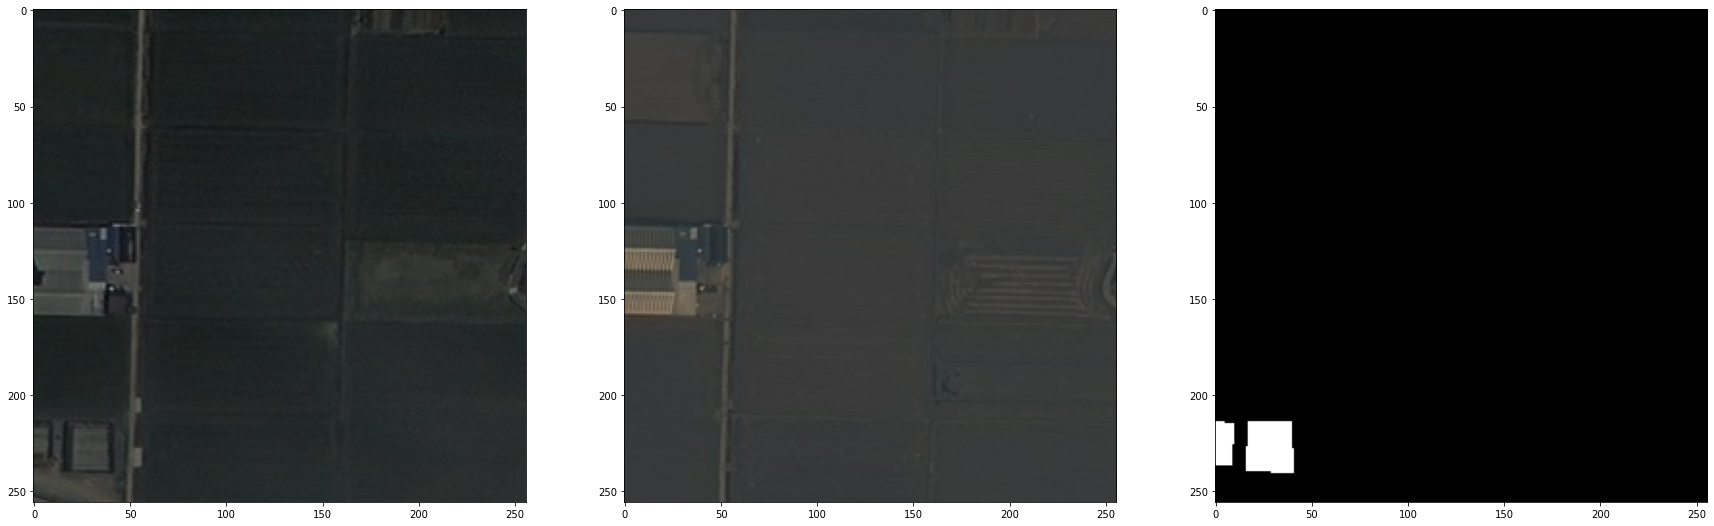

In [88]:
# Dataset test - unaugmented
for x,y in test_dataset.take(1):
  pass
idx = 0
plt.figure(figsize=(3*10,10))
plt.subplot(131)
plt.imshow(x[idx,:,:,:3].numpy())
plt.subplot(132)
plt.imshow(x[idx,:,:,3:6].numpy())
plt.subplot(133)
plt.imshow(y[idx].numpy().argmax(-1),cmap='gray')

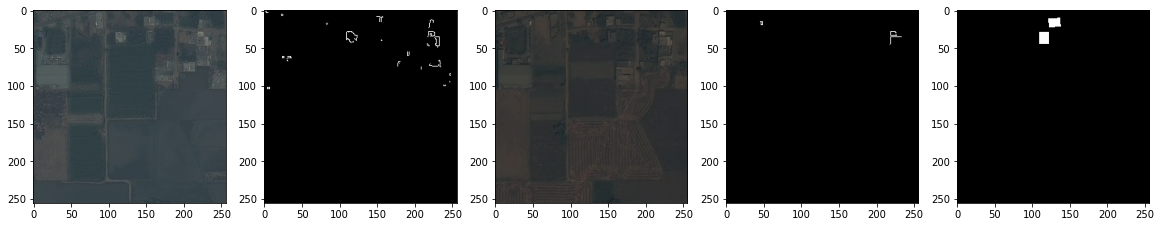

In [85]:
# Dataset test - edge augmented
for x,y in test_dataset.take(1):
  pass
idx = 0
plt.figure(figsize=(20,4))
plt.subplot(151)
plt.imshow(x[idx,:,:,:3].numpy())
plt.subplot(152)
plt.imshow(x[idx,:,:,6].numpy(),cmap='gray')
plt.subplot(153)
plt.imshow(x[idx,:,:,3:6].numpy())
plt.subplot(154)
plt.imshow(x[idx,:,:,7].numpy(),cmap='gray')
plt.subplot(155)
plt.imshow(y[idx].numpy().argmax(-1),cmap='gray')

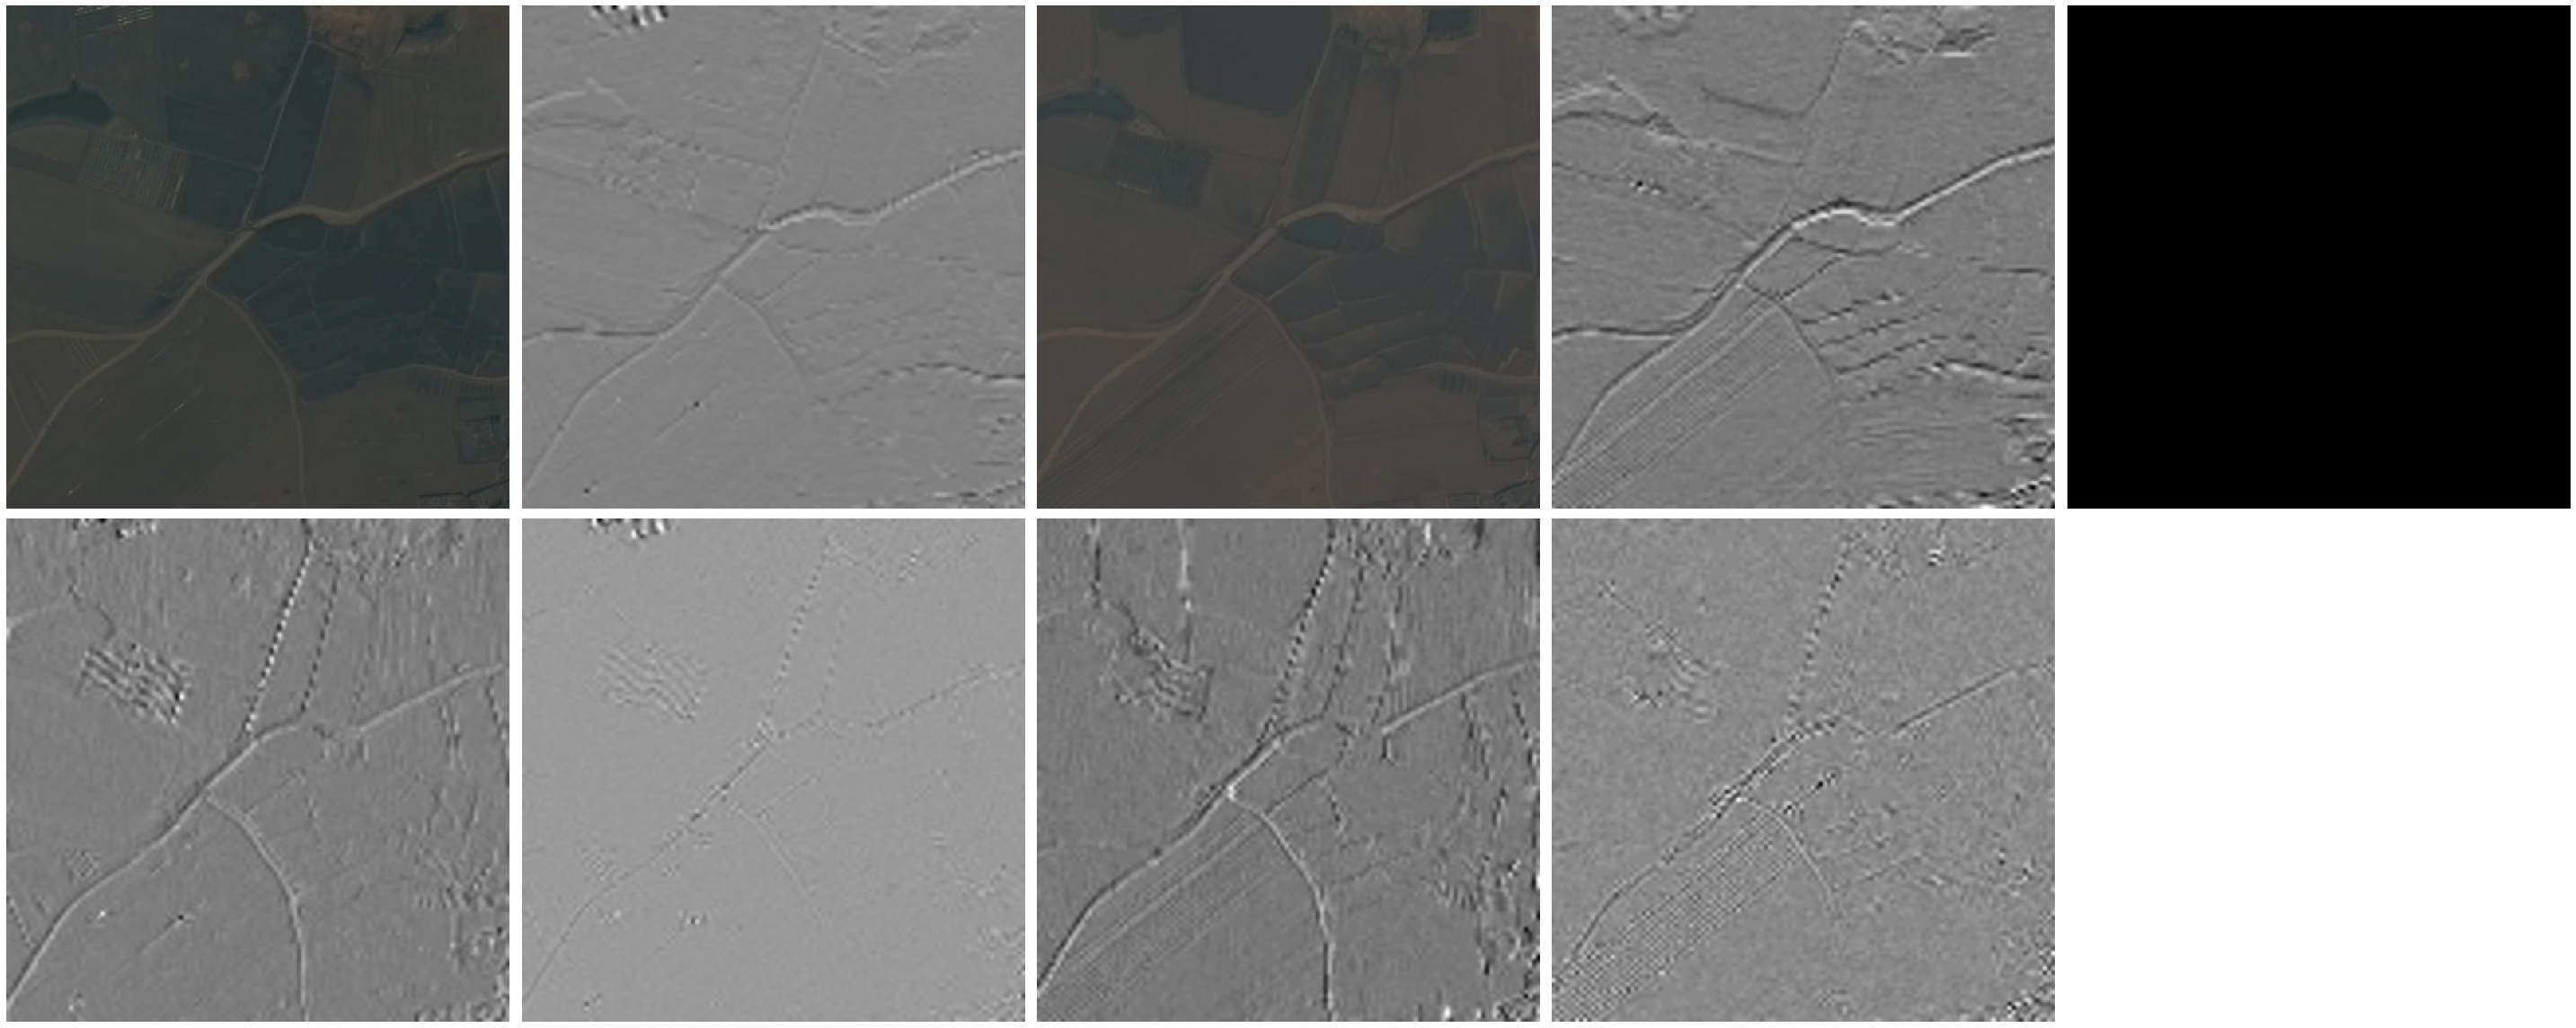

In [82]:
# Dataset test - mra augmented
for x,y in test_dataset.take(1):
  pass
idx = 5
plt.figure(figsize=(40,16))
plt.subplot(251)
plt.imshow(x[idx,:,:,:3].numpy())
plt.axis('off')
plt.tight_layout()
plt.subplot(252)
plt.imshow(x[idx,:,:,6].numpy(),cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.subplot(256)
plt.imshow(x[idx,:,:,7].numpy(),cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.subplot(257)
plt.imshow(x[idx,:,:,8].numpy(),cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.subplot(253)
plt.imshow(x[idx,:,:,3:6].numpy())
plt.axis('off')
plt.tight_layout()
plt.subplot(254)
plt.imshow(x[idx,:,:,9].numpy(),cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.subplot(258)
plt.imshow(x[idx,:,:,10].numpy(),cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.subplot(259)
plt.imshow(x[idx,:,:,11].numpy(),cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.subplot(255)
plt.imshow(y[idx].numpy().argmax(-1),cmap='gray')
plt.axis('off')
plt.tight_layout()

# Move savefile to drive